In [62]:
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [63]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [124]:
# Indexes of all landmarks
NOSE = mp_pose.PoseLandmark.NOSE.value
LEFT_EYE_INNER = mp_pose.PoseLandmark.LEFT_EYE_INNER.value
LEFT_EYE = mp_pose.PoseLandmark.LEFT_EYE.value
LEFT_EYE_OUTER = mp_pose.PoseLandmark.LEFT_EYE_OUTER.value
RIGHT_EYE_INNER = mp_pose.PoseLandmark.RIGHT_EYE_INNER.value
RIGHT_EYE = mp_pose.PoseLandmark.RIGHT_EYE.value
RIGHT_EYE_OUTER = mp_pose.PoseLandmark.RIGHT_EYE_OUTER.value
LEFT_EAR = mp_pose.PoseLandmark.LEFT_EAR.value
RIGHT_EAR = mp_pose.PoseLandmark.RIGHT_EAR.value
MOUTH_LEFT = mp_pose.PoseLandmark.MOUTH_LEFT.value
MOUTH_RIGHT = mp_pose.PoseLandmark.MOUTH_RIGHT.value
LEFT_SHOULDER = mp_pose.PoseLandmark.LEFT_SHOULDER.value
RIGHT_SHOULDER = mp_pose.PoseLandmark.RIGHT_SHOULDER.value
LEFT_ELBOW = mp_pose.PoseLandmark.LEFT_ELBOW.value
RIGHT_ELBOW = mp_pose.PoseLandmark.RIGHT_ELBOW.value
LEFT_WRIST = mp_pose.PoseLandmark.LEFT_WRIST.value
RIGHT_WRIST = mp_pose.PoseLandmark.RIGHT_WRIST.value
LEFT_PINKY = mp_pose.PoseLandmark.LEFT_PINKY.value
RIGHT_PINKY = mp_pose.PoseLandmark.RIGHT_PINKY.value
LEFT_INDEX = mp_pose.PoseLandmark.LEFT_INDEX.value
RIGHT_INDEX = mp_pose.PoseLandmark.RIGHT_INDEX.value
LEFT_THUMB = mp_pose.PoseLandmark.LEFT_THUMB.value
RIGHT_THUMB = mp_pose.PoseLandmark.RIGHT_THUMB.value
LEFT_HIP = mp_pose.PoseLandmark.LEFT_HIP.value
RIGHT_HIP = mp_pose.PoseLandmark.RIGHT_HIP.value
LEFT_KNEE = mp_pose.PoseLandmark.LEFT_KNEE.value
RIGHT_KNEE = mp_pose.PoseLandmark.RIGHT_KNEE.value
LEFT_ANKLE = mp_pose.PoseLandmark.LEFT_ANKLE.value
RIGHT_ANKLE = mp_pose.PoseLandmark.RIGHT_ANKLE.value
LEFT_HEEL = mp_pose.PoseLandmark.LEFT_HEEL.value
RIGHT_HEEL = mp_pose.PoseLandmark.RIGHT_HEEL.value
LEFT_FOOT_INDEX = mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value
RIGHT_FOOT_INDEX = mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value

# Indexes of landmarks for pose classification and correction
main_lnms = [LEFT_SHOULDER, RIGHT_SHOULDER, LEFT_ELBOW, RIGHT_ELBOW,
            LEFT_WRIST, RIGHT_WRIST, LEFT_HIP, RIGHT_HIP, LEFT_KNEE,
            RIGHT_KNEE, LEFT_ANKLE, RIGHT_ANKLE]

ang_ps_arr = [
    (RIGHT_WRIST, RIGHT_ELBOW, RIGHT_SHOULDER), # 1 (16, 14, 12)
    (LEFT_ELBOW, LEFT_SHOULDER, LEFT_HIP), # 2 (13, 11, 23)
    (RIGHT_ELBOW, RIGHT_SHOULDER, RIGHT_HIP), # 3 (14, 12, 24)
    (LEFT_WRIST, LEFT_ELBOW, LEFT_SHOULDER), # 4 (15, 13, 11)
    (RIGHT_SHOULDER, RIGHT_HIP, RIGHT_KNEE), # 5 (12, 24, 26)
    (LEFT_SHOULDER, LEFT_HIP, LEFT_KNEE), # 6 (11, 23, 25)
    (RIGHT_HIP, RIGHT_KNEE, RIGHT_ANKLE), # 7 (24, 26, 28)
    (LEFT_HIP, LEFT_KNEE, LEFT_ANKLE), # 8 (23, 25, 27)
]

x, y, z = 0, 1, 2
axis_dict = {x:'x', y:'y', z:'z'}

In [125]:
poses = {}
pose_names = ['t', 'warrior', 'tree']

In [126]:
duration = 3
part = 'start'
static = True

In [128]:
# Init all necessary dictionary keys
parts_p = ['start_p', 'end_p']
sides = ['left', 'right']
for name in pose_names:
    poses[name] = {}
    poses[name][part] = {}
    poses[name][part]['orientation'] = {}
    poses[name][part]['orientation'][parts_p[0]] = {}
    poses[name][part]['orientation'][parts_p[1]] = {}
    poses[name][part]['pivots']=  {}
    poses[name][part]['pivots'][sides[0]] =  {}
    poses[name][part]['pivots'][sides[1]] =  {}
    poses[name][part]['angles'] = {}

In [129]:
def find_angle(lmList, ps_idx):
    # Get the points coordinates from the landmarks
    x1, y1, _ = lmList[ps_idx[0]]
    x2, y2, _ = lmList[ps_idx[1]]
    x3, y3, _ = lmList[ps_idx[2]]
    # Calculate the Angle
    angle = abs(math.degrees(math.atan2(y3 - y2, x3 - x2) 
                        - math.atan2(y1 - y2, x1 - x2)))
    return angle

# TODO: DRY
def find_orient_angle(ps):
    x1, y1 = ps[0]
    x2, y2 = ps[1]
    x3, y3 = ps[2]
    angle = abs(math.degrees(math.atan2(y3 - y2, x3 - x2) 
                        - math.atan2(y1 - y2, x1 - x2)))
    return angle

In [130]:
for name in pose_names:
    # Read image
    sample_img = cv2.imread('imgs/'+name+'.jpg')
    # Flip the frame horizontally for natural (selfie-view) visualization.
    sample_img = cv2.flip(sample_img, 1)
    # Perform pose detection after converting the image into RGB format.
    results = []
    for lm in pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)).pose_landmarks.landmark:
        cx, cy, cz = lm.x, lm.y, lm.z
        results.append([cx, cy, cz])
    # Calculate orientation points and ration between its angles
    orient_start_p = results[RIGHT_HIP]
    orient_end_p = results[LEFT_HIP]
    orient_start_ang = find_orient_angle(( (0, orient_start_p[y]), (0,0), (orient_start_p[x], orient_start_p[y]) ))
    orient_end_ang = find_orient_angle(( (0, orient_end_p[y]), (0,0), (orient_end_p[x], orient_end_p[y]) ))
    orient_ang_ratio = orient_start_ang / orient_end_ang
    # Set orientation to dictionary
    for part_p in parts_p:
        for axis, axis_str in axis_dict.items():
            poses[name][part]['orientation'][part_p][axis_str] = orient_start_p[axis] if part_p == parts_p[0] else orient_end_p[axis]

    poses[name][part]['orientation']['ang_ratio'] = orient_ang_ratio
    # Set pose duration if its static pose
    if static:
        poses[name]['duration'] = duration
    # Calculate pose pivots
    # TODO: Calculate pivots depending on orientation (coach could lays horizontally --> pivots would be HIP and SHOULDER)
    right_hip =  results[RIGHT_HIP]
    right_shoulder = results[RIGHT_SHOULDER]
    # If HIP's height is bigger than SHOULDER --> the coach pivots is its arms, otherwise --> its legs.
    piv_left = results[LEFT_WRIST] if right_hip[y] > right_shoulder[y] else results[LEFT_ANKLE]
    piv_right = results[RIGHT_WRIST] if right_hip[y] > right_shoulder[y] else results[RIGHT_ANKLE]
    # Set pose pivots to dictionary
    for side in sides:
        for axis, axis_str in axis_dict.items():
            poses[name][part]['pivots'][side][axis_str] = piv_left[axis] if side == sides[0] else piv_right[axis]
    # Add angles to dictionary
    for ang_ps in ang_ps_arr:
        poses[name][part]['angles'][str(ang_ps)] = find_angle(results, ang_ps)

# print(poses)

In [131]:
# Save poses relative points to json
import json

with open('poses.json', 'w') as fp:
    json.dump(poses, fp)

In [ ]:

# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

results = pose.process(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)).pose_landmarks.landmark

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

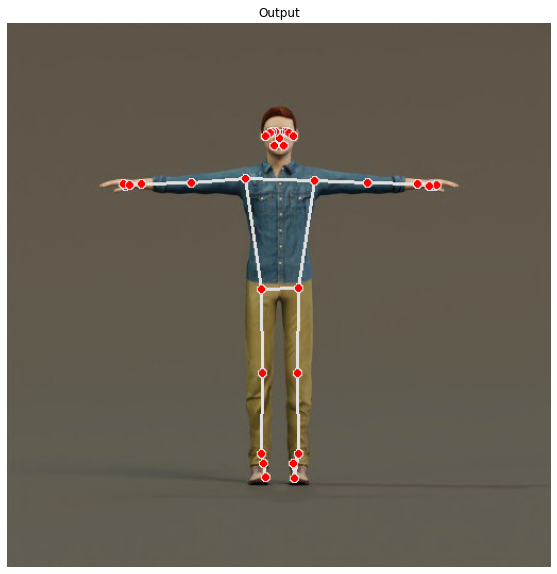

In [17]:
sample_img2 = cv2.imread('imgs/t.jpg')
results2 = pose.process(cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB))

mp_drawing.draw_landmarks(image=sample_img2, landmark_list=results2.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
# Specify a size of the figure.
fig = plt.figure(figsize = [10, 10])

# Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
plt.title("Output");plt.axis('off');plt.imshow(sample_img2[:,:,::-1]);plt.show()